In [1]:
!pip install transformers torch accelerate -U
%pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 32.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import json

import torch
from transformers import AlbertForSequenceClassification, AlbertTokenizer, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import evaluate
from transformers import TrainerCallback

In [3]:
# data_path = 'data/movies'
# metadata = pd.read_csv(os.path.join(data_path, 'movies_metadata.csv'), low_memory=False)
metadata = pd.read_csv("movies_metadata.csv", low_memory=False)

def convert_metadata(metadata):
    metadata['release_date'] = pd.to_datetime(metadata['release_date'], errors='coerce')
    metadata['budget'] = pd.to_numeric(metadata['budget'], errors='coerce')
    metadata['revenue'] = pd.to_numeric(metadata['revenue'], errors='coerce')
    metadata['runtime'] = pd.to_numeric(metadata['runtime'], errors='coerce')
    return metadata

metadata = convert_metadata(metadata)

metadata = metadata[pd.notnull(metadata['title'])]
metadata = metadata[pd.notnull(metadata['budget'])]
metadata = metadata[pd.notnull(metadata['revenue'])]
metadata = metadata[pd.notnull(metadata['runtime'])]
metadata = metadata[pd.notnull(metadata['release_date'])]

metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').dt.year.astype('Int64')
metadata['genre_list'] = metadata['genres'].apply(lambda x: [genre['name'] for genre in ast.literal_eval(x)])
metadata.info()


<ipython-input-3-c0aa252a1ef7>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').dt.year.astype('Int64')


<class 'pandas.core.frame.DataFrame'>
Index: 45130 entries, 0 to 45465
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  45130 non-null  object        
 1   belongs_to_collection  4481 non-null   object        
 2   budget                 45130 non-null  float64       
 3   genres                 45130 non-null  object        
 4   homepage               7766 non-null   object        
 5   id                     45130 non-null  object        
 6   imdb_id                45118 non-null  object        
 7   original_language      45119 non-null  object        
 8   original_title         45130 non-null  object        
 9   overview               44435 non-null  object        
 10  popularity             45130 non-null  object        
 11  poster_path            44808 non-null  object        
 12  production_companies   45130 non-null  object        
 13  produc

In [4]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(metadata['genre_list'])

# tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
# model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(mlb.classes_))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(mlb.classes_))


tokenized_inputs = tokenizer(list(metadata['title']), truncation=True, padding=True, return_tensors="pt")
labels = torch.tensor(y, dtype=torch.float32)

train_inputs, eval_inputs, train_labels, eval_labels = train_test_split(tokenized_inputs['input_ids'], labels, test_size=0.2, random_state=42)

clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
   return 1/(1 + np.exp(-x))

def compute_metrics(eval_pred):
   predictions, labels = eval_pred
   predictions = sigmoid(predictions)
   predictions = (predictions > 0.5).astype(int).reshape(-1)
   return clf_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))

class MovieGenreDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings[idx],
            'attention_mask': self.encodings[idx].bool(),
            'labels': self.labels[idx]
        }
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MovieGenreDataset(train_inputs, train_labels)
eval_dataset = MovieGenreDataset(eval_inputs, eval_labels)

training_args = TrainingArguments(
    per_device_train_batch_size=64,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    output_dir="./results",
    num_train_epochs=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

model.save_pretrained("./fine_tuned_bert_model")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.277600,0.245292,0.906753,0.310829,0.598738,0.209898
2,0.236500,0.238609,0.908680,0.399913,0.585233,0.303732
3,0.211400,0.243333,0.907262,0.432066,0.558989,0.352115
4,0.188600,0.255805,0.905146,0.426423,0.540874,0.351949
5,0.165900,0.274944,0.902072,0.429668,0.515762,0.368206
6,0.146100,0.287742,0.900820,0.437865,0.506575,0.385568
7,0.130300,0.306720,0.899585,0.431096,0.498476,0.379762
8,0.105500,0.318353,0.899069,0.434372,0.495222,0.386840
9,0.096900,0.327454,0.898698,0.432662,0.492861,0.385568
10,0.091700,0.331683,0.898931,0.435821,0.494388,0.389660


In [5]:
test_title = "The Haunting"
inputs = tokenizer(test_title, return_tensors="pt", truncation=True, padding=True)
inputs.to(torch.device('cuda'))

model.to(torch.device('cuda'))
outputs = model(**inputs)
predicted_scores = torch.sigmoid(outputs.logits).detach().cpu().numpy()

threshold = 0.0
predicted_indices = predicted_scores[0] > threshold
predicted_genres = mlb.classes_[predicted_indices]
predicted_probabilities = predicted_scores[0][predicted_indices]

genre_prob_pairs = [(genre, probability) for genre, probability in zip(predicted_genres, predicted_probabilities)]
sorted_genre_prob_pairs = sorted(genre_prob_pairs, key=lambda x: x[1], reverse=True)

for genre, probability in sorted_genre_prob_pairs:
    print(f"Genre: {genre}, Probability: {probability:.4f}")

Genre: Horror, Probability: 0.9765
Genre: Thriller, Probability: 0.8712
Genre: Mystery, Probability: 0.6471
Genre: Drama, Probability: 0.0742
Genre: Fantasy, Probability: 0.0560
Genre: Crime, Probability: 0.0255
Genre: TV Movie, Probability: 0.0198
Genre: Foreign, Probability: 0.0151
Genre: Science Fiction, Probability: 0.0143
Genre: Romance, Probability: 0.0124
Genre: Comedy, Probability: 0.0105
Genre: Documentary, Probability: 0.0078
Genre: Western, Probability: 0.0073
Genre: Animation, Probability: 0.0043
Genre: Adventure, Probability: 0.0041
Genre: Action, Probability: 0.0038
Genre: War, Probability: 0.0037
Genre: Music, Probability: 0.0031
Genre: Family, Probability: 0.0028
Genre: History, Probability: 0.0016


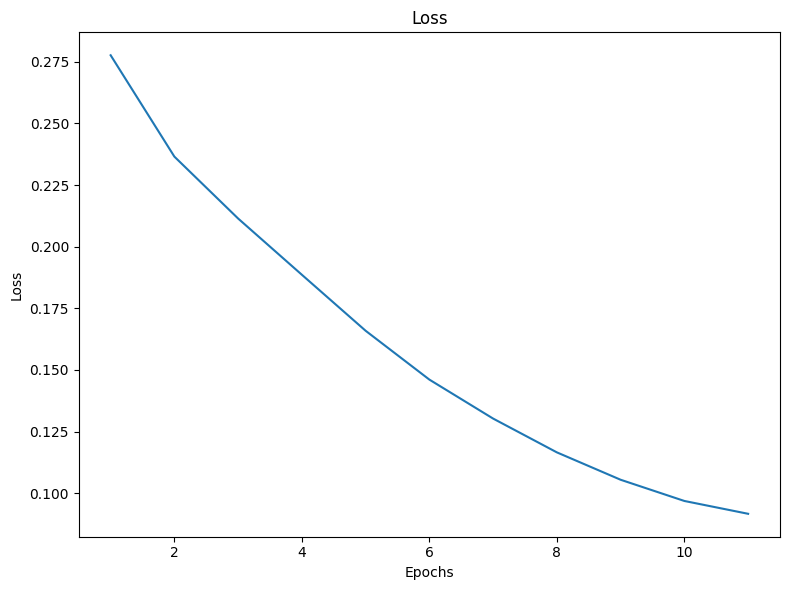

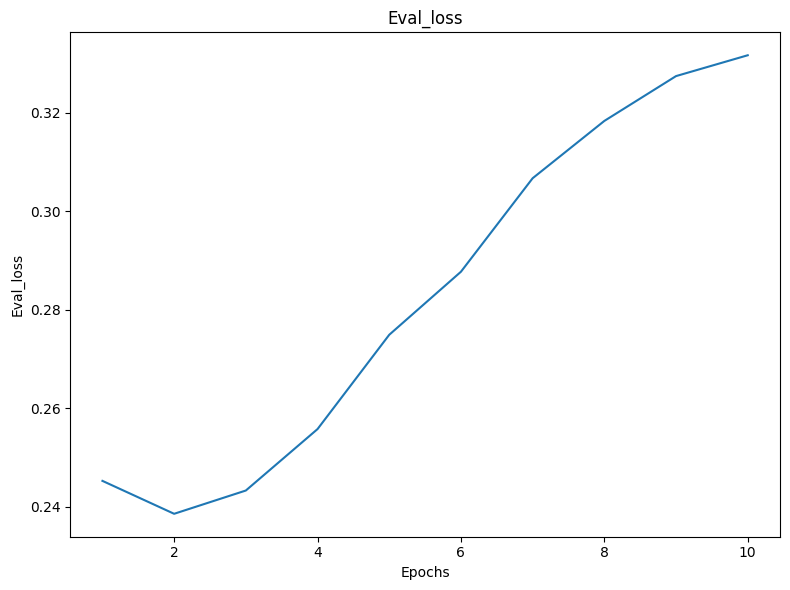

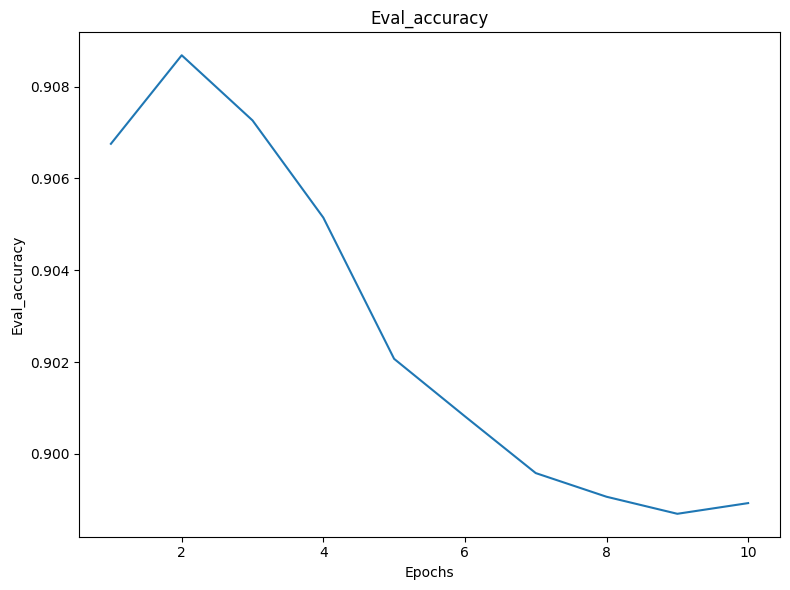

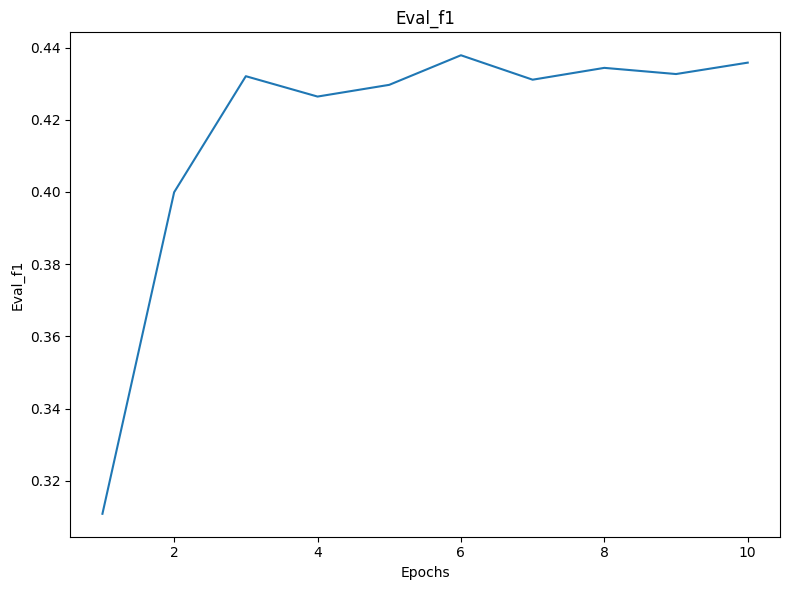

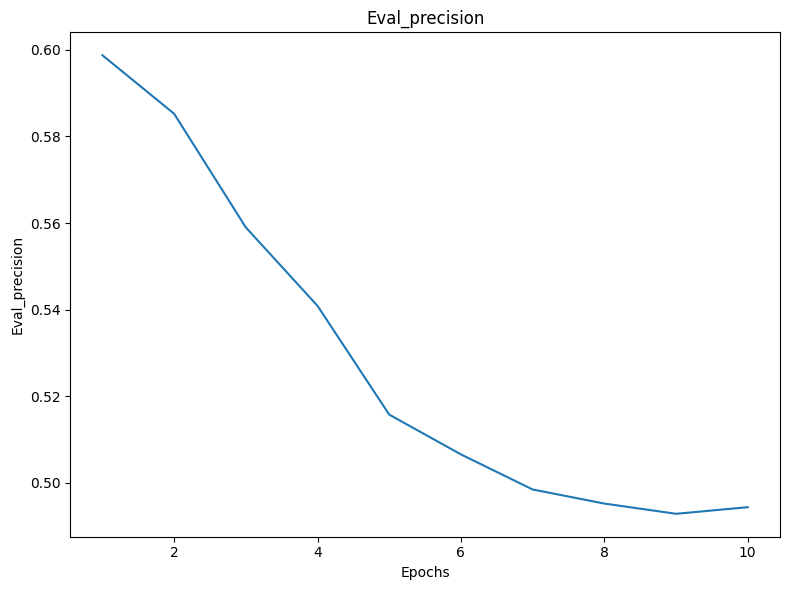

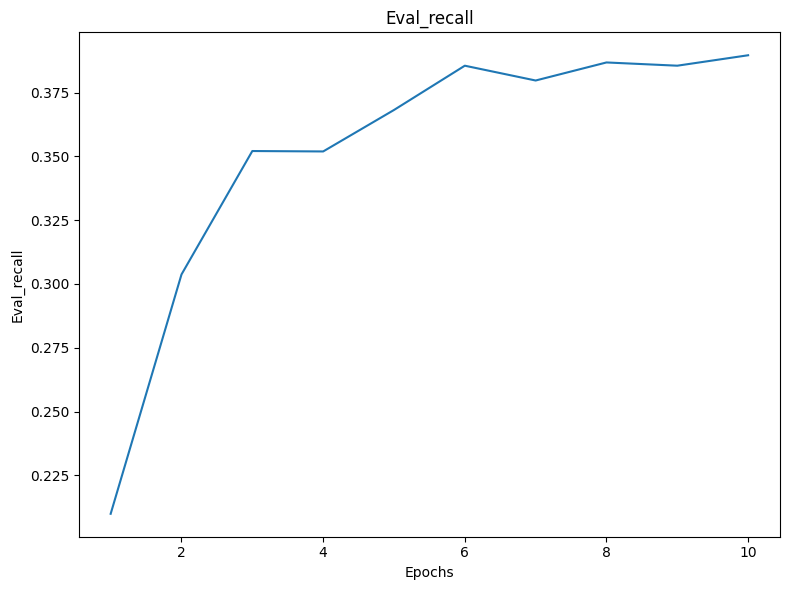

In [6]:
train_logs = trainer.state.log_history

metrics_to_plot = ['loss', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']

for metric in metrics_to_plot:
    metric_values = [log.get(metric) for log in train_logs if log.get(metric) is not None]
    epochs = range(1, len(metric_values) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, metric_values)
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()}")
    plt.tight_layout()
    plt.show()

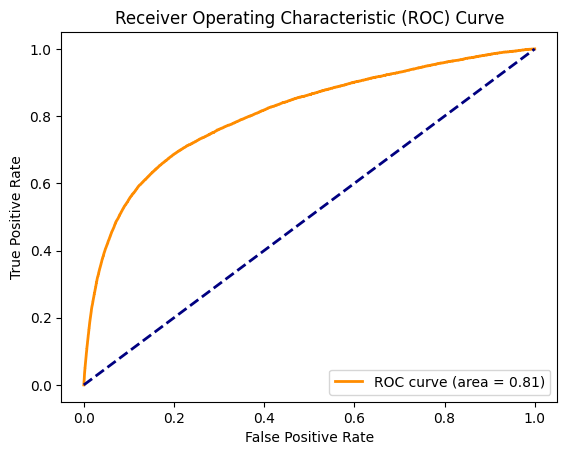

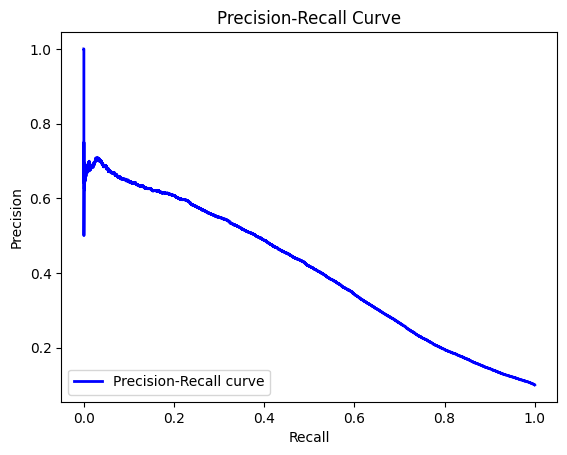

In [7]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

eval_predictions = trainer.predict(eval_dataset)
predictions = eval_predictions.predictions
labels = eval_predictions.label_ids

predicted_probabilities = sigmoid(predictions)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

fpr, tpr, _ = roc_curve(labels.flatten(), predictions.flatten())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(labels.flatten(), predictions.flatten())

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

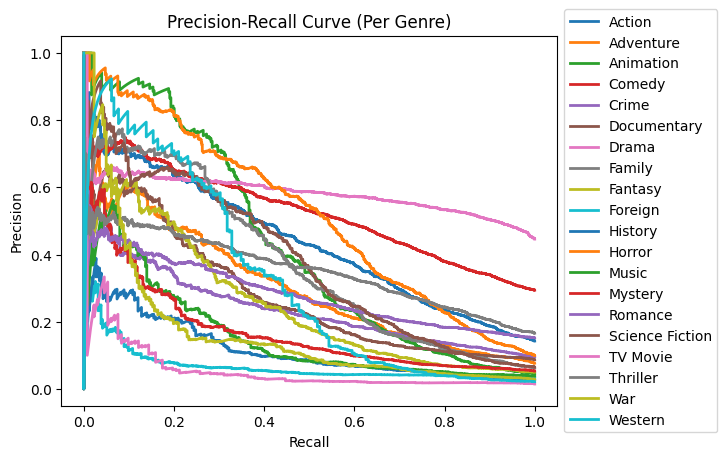

In [8]:
genre_labels = mlb.classes_

plt.figure()

for class_index in range(len(genre_labels)):
    precision, recall, _ = precision_recall_curve(labels[:, class_index], predictions[:, class_index])
    plt.plot(recall, precision, lw=2, label=genre_labels[class_index])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Per Genre)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
